<a href="https://colab.research.google.com/github/BrunoPinos/Categoriser-automatiquement-des-questions/blob/main/p5_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [4]:
# data analysis and wrangling
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np

# text
import re
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from IPython.display import display, HTML

# Save objects
import joblib

# Set working directory
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/P5')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import

**SQL**  
I get 50,000 posts for every 10,000,000, the posts retrieved have a score> 10 and are questions

for n in range(1, 7):  
SELECT Id, Body, Title, Tags  
FROM Posts  
WHERE (Score >= 10) AND (PostTypeId = 1) AND (Id < n * 10000000) AND (  
  Id >= (n - 1) * 10000000) AND (  

**Read**

In [5]:
n_files = 6
list_files = [pd.read_csv('./Data/QueryResults (' + str(n+1) + ').csv',
                          index_col='Id') for n in range(n_files)]

df = pd.concat(list_files, axis=0)
df

,Body,Title,Tags
Id,,,
10000005,<blockquote>\n<p><strong>Possible Duplicate:</...,PHP Sort array by field?,<php><arrays><sorting>
10000083,<p>I want to make an eventHandler that passes ...,Javascript event handler with parameters,<javascript><events><event-handling><handler>
10000335,<p><strong>Short version of question:</strong>...,How to use debug version of libc,<linux><gdb><libc><ldd>
10003270,"<p>I have declared a struct, and I try to pass...",GCC: array type has incomplete element type,<c><arrays><gcc><struct>
10003562,<p>I have a view on a storyboard the has a but...,How to segue back to a UIViewController that's...,<objective-c><ios><storyboard><segue>
...,...,...,...
1213074,<p>I'm trying to drag data from the Winforms p...,"WinForms Interop, Drag & Drop from WinForms ->...",<wpf><winforms><interop><drag-and-drop>
1213127,<p>Is there a way for a Java program to detect...,Detect OS Sleep and Wake Up events in Java,<java><mysql><database-connection><sleep>
1213137,<p>I know I can change the UITableView propert...,Is there a way to remove the separator line fr...,<iphone><uitableview>


# Pretreatment

I create text with title + body.  
I follow transformations on 2 question.  

In [6]:
sample = np.random.choice(len(df), 2)

def random_display(docs, sample):
    for s in sample:
        print(docs.iloc[s], '\n'+'-'*20+'\n'*2)

In [7]:
texts = (df.Title + ' ' +df.Body)


random_display(texts, sample)

How do you convert hex to decimal using VB.NET? <p>I need to convert hex to a decimal in <a href="http://en.wikipedia.org/wiki/Visual_Basic_.NET" rel="noreferrer">VB.NET</a>. Found several examples in C#, but when I tried to convert to VB.NET I was not successful. An example of a hexadecimal number that I am trying to convert is "A14152464C203230304232323020572F544947455234352E".</p>
 
--------------------


Assigning TCP/IP Ports for In-House Application Use <p>I've written a WCF Service hosted by a Windows Service and it needs to listen on a known TCP/IP port.  From what range can I safely allocate a port for use within my organization?  That port will be embedded in the config files for the service and the clients that are consuming the service.</p>
 
--------------------




The first part of our job is to clean up the text

1.   Remove superfluous parts: code parts, HTML tags, punctuation... 
2.   Create tokens: i.e. separate their text for each document into a list of  words
3.   Remove stopwords: words considered too common to be interesting in our analysis
4.   Lemmatize: transform all the words into a basic form whatever the form in which it appears in the document (plural, conjugated verb, feminine form ...)

In [51]:
# Stemming function

ps = nltk.stem.SnowballStemmer('english')

def stemming(doc):
    return [ps.stem(word) for word in doc]

# Lemmatization function
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(doc, nlp, banned_postags=['PUNCT', 'DET', 'PRON', 'CONJ',
                                            'ADV', 'INTJ']):
    doc = nlp(doc)
    return [token.lemma_ for token in doc if token.pos_ not in banned_postags]
    

# Remove stopwords
stop_words = stopwords.words('english')

# stop_words.extend([])
def remove_stopwords(doc):
    return " ".join([word for word in doc if word not in stop_words])  

I try stemming

In [55]:
# stop_words.extend([]) for stem
def remove_stopwords_0(doc):
    return [word for word in doc if word not in stop_words]

                      
# All processing
texts_cleaned_stem = (texts
                      # delete code parts
                      .apply(lambda x: re.sub('<code>(.|\n)*?</code>', '', x))
                      # remove HTML tags
                      .apply(lambda x: re.sub('<[^<]+?>', '', x))
                      # token
                      .apply(lambda x: simple_preprocess(x, min_len=3,
                                                         deacc=False))
                      # remove stop word
                      .apply(remove_stopwords_0)
                      # stem
                      .apply(lambda x: stemming(x))
                     )

random_display(texts_cleaned_stem, sample)

['convert', 'hex', 'decim', 'use', 'net', 'need', 'convert', 'hex', 'decim', 'net', 'found', 'sever', 'exampl', 'tri', 'convert', 'net', 'success', 'exampl', 'hexadecim', 'number', 'tri', 'convert'] 
--------------------


['assign', 'tcp', 'port', 'hous', 'applic', 'use', 'written', 'wcf', 'servic', 'host', 'window', 'servic', 'need', 'listen', 'known', 'tcp', 'port', 'rang', 'safe', 'alloc', 'port', 'use', 'within', 'organ', 'port', 'embed', 'config', 'file', 'servic', 'client', 'consum', 'servic'] 
--------------------




Lemmatization

In [11]:
# All processing
texts_cleaned = (texts
                 # delete code parts
                 .apply(lambda x: re.sub('<code>(.|\n)*?</code>', '', x))
                 # remove HTML tags
                 .apply(lambda x: re.sub('<[^<]+?>', '', x))
                 # token
                 .apply(lambda x: simple_preprocess(x, min_len=3, deacc=False))
                 # remove stop word
                 .apply(remove_stopwords)
                 # lemmatization
                 .apply(lambda x: lemmatization(x, nlp=nlp))
                )

random_display(texts_cleaned, sample)

['convert', 'hex', 'decimal', 'use', 'net', 'need', 'convert', 'hex', 'decimal', 'net', 'find', 'several', 'example', 'try', 'convert', 'net', 'successful', 'example', 'hexadecimal', 'number', 'try', 'convert'] 
--------------------


['assign', 'tcp', 'port', 'house', 'application', 'use', 'write', 'wcf', 'service', 'host', 'windows', 'service', 'need', 'listen', 'know', 'tcp', 'port', 'range', 'allocate', 'port', 'use', 'within', 'organization', 'port', 'embed', 'config', 'file', 'service', 'client', 'consume', 'service'] 
--------------------




In our selected examples, we observe a much smaller number of remaining words, compared to the raw documents.

Now is the time to normalize our text, namely to put it in a format in which our model will be able to understand it. To do this, we will first create a dictionary which will assign a unique identifier to each word present in all the documents. We also display the number of words present in this dictionary

In [ ]:
dictionary = Dictionary(texts_cleaned)
print("Taille du dictionnaire: ",len(dictionary))

Taille du dictionnaire:  62400


In order to make sure that these words can help us at least to find interesting patterns in our data at the time of modeling, we remove from the dictionary the words which do not appear in at least 50 different documents.

In [ ]:
dictionary.filter_extremes(no_below=50)
print("Taille du dictionnaire: ", len(dictionary))

Taille du dictionnaire:  3506


With this filtering, we have removed more than 80% of the words in the dictionary, which could have been a source of noise once they became descriptors. Also, in order not to have too common words (like stopwords), let's take a look at the most common items

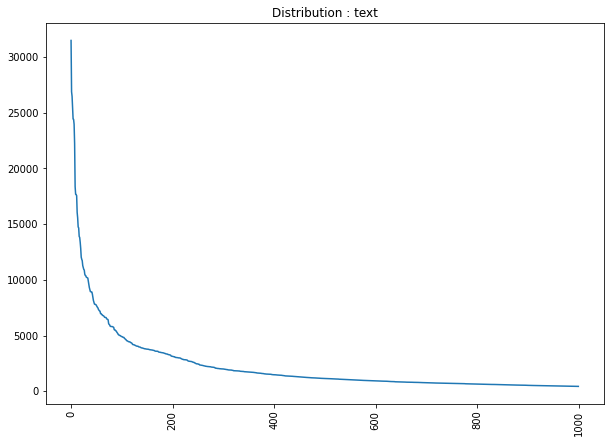

In [ ]:
words_sorted = sorted(dictionary.dfs.items(), key=lambda x: x[1], reverse=True)
id2token = {value: key for key, value in dictionary.token2id.items()}

list_count = [count for e, (i, count) in enumerate(words_sorted[:1000])]
fig = plt.figure(1, figsize=(10, 7))
sn.lineplot(x = range(0, 1000), y = list_count)
plt.xticks(rotation=90)
plt.title('Distribution : text')
plt.show()

In [ ]:
print("Mots les plus fréquents du dictionnaire:")
for e, (i, count) in enumerate(words_sorted[:100]):
    print(f"{e+1:2} {id2token[i]:15} {count:5}")

Mots les plus fréquents du dictionnaire:
 1 get             31488
 2 like            26885
 3 try             26472
 4 want            25482
 5 code            24441
 6 work            24406
 7 way             23965
 8 would           22237
 9 file            18380
10 find            17682
11 one             17660
12 know            17561
13 need            16064
14 follow          15568
15 error           14754
16 make            14669
17 example         13907
18 create          13809
19 run             13379
20 look            12828
21 problem         12042
22 see             11855
23 seem            11728
24 set             11288
25 question        11102
26 add             10948
27 good            10887
28 value           10517
29 time            10402
30 method          10381
31 new             10251
32 could           10224
33 change          10203
34 thank           10168
35 application      9908
36 call             9596
37 function         9317
38 give             9134
39 user  

We decide to delete the 77 most frequent words + 13 others bad words.


In [ ]:
to_delete = [id2token[i] for e, (i, count) in enumerate(words_sorted[:70])]

list_remove = ['java', 'python', 'list', 'net',
               'class', 'application']

for word in list_remove:
  to_delete.remove(word) 

bad_ids = [dictionary.token2id[token] for token in to_delete]

dictionary.filter_tokens(bad_ids=bad_ids)

And finally, to conclude our pre-processing part, we create our bag of words. This representation makes it possible to count the number of occurrences of each word in the dictionary for each document. The resulting dataframe will serve as input data to our model

In [ ]:
corpus = texts_cleaned.apply(dictionary.doc2bow)
random_display(corpus, sample)

[(10, 2), (25, 1), (65, 1), (124, 1), (196, 2), (316, 1), (420, 1), (505, 2), (509, 1), (547, 3), (600, 1), (792, 1), (918, 1), (1061, 4), (1077, 1), (1367, 1), (1804, 1), (1856, 3)] 
--------------------


[(46, 1), (77, 1), (190, 1), (193, 1), (204, 1), (239, 1), (295, 5), (300, 5), (322, 1), (346, 2), (399, 1), (417, 2), (442, 1), (532, 1), (538, 1), (607, 2), (625, 2), (635, 1), (663, 2), (666, 2), (700, 1), (799, 1), (827, 1), (1061, 1), (1196, 1), (1281, 1), (1536, 1), (1776, 1), (1786, 2), (1993, 2), (2082, 1), (2152, 1), (2217, 1), (2279, 2), (2565, 1), (3218, 1)] 
--------------------




I save my objects

In [ ]:
joblib.dump(corpus, 'corpus.sav')
joblib.dump(dictionary, 'dictionary.sav')
joblib.dump(df, 'df.sav')
joblib.dump(texts_cleaned, 'texts_cleaned.sav')

['texts_cleaned.sav']